In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from enum import Enum
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import random
import datetime

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [2]:
df_data = pd.read_csv('./Train_Mouse.csv')
print(df_data.shape)
df_data.head()


(11633, 7)


uid                            session_id  \
0  18d23c24-c5ea-46ff-8318-17e743c24317  c4af3096-5a73-4d70-a8e6-f4ad64bd008a   
1  25f4ed5c-12d6-4164-827b-35ab5e9d84e9  c4af3096-5a73-4d70-a8e6-f4ad64bd008a   
2  29716657-2778-4f32-a14c-d062aa0d8c03  c4af3096-5a73-4d70-a8e6-f4ad64bd008a   
3  37cb2b1e-e479-4912-ad70-b6834b5fc86c  c4af3096-5a73-4d70-a8e6-f4ad64bd008a   
4  00dc619a-0139-4c27-b13e-dcc0b668c4f9  c4af3096-5a73-4d70-a8e6-f4ad64bd008a   

               user_id      timestamp  event_type  screen_x  screen_y  
0 -2416201411472988629  1655993031186           2    1087.0     442.0  
1 -2416201411472988629  1655993031135           2    1324.0     468.0  
2 -2416201411472988629  1655993031102           2    1504.0     487.0  
3 -2416201411472988629  1655993031218           2     965.0     428.0  
4 -2416201411472988629  1655993039885           2    1919.0    1039.0

# Data Preprocessing 

In [3]:
### make label encoding of the user_id and session_id

user_id_array = df_data['user_id'].unique()
user_id_map = {val:idx for idx,val in enumerate(user_id_array)}
df_data['user_id_new'] = df_data['user_id'].map(lambda x: user_id_map[x])
# now we have user id from 0 to 19

session_id_array = df_data['session_id'].unique()
session_id_map = {val:idx for idx,val in enumerate(session_id_array)}
df_data['session_id_new'] = df_data['session_id'].map(lambda x: session_id_map[x])
# now we have session id from 0 to 119

In [4]:
# sorted the timestamp groupby session_id and reset the index
df_data = df_data.sort_values('timestamp').reset_index()
df_data['index'] = df_data.index

In [5]:
# get dummy one-hot encoding of the event-type
event_list = ['', 'RELEASE', 'MOVE', 'WHEEL', 'DRAG', 'CLICK']
df_data['e'] = df_data['event_type'].map(lambda x: event_list[x])

one_hot_df = pd.get_dummies(df_data['e'], prefix='event')
pd.get_dummies(df_data['e'], prefix='event')
df_data = pd.concat([df_data, one_hot_df], axis=1)

categorial_cols = ['event_MOVE', 'event_WHEEL', 'event_DRAG', 'event_CLICK']

# EDA

In [6]:
from datetime import datetime

# take a look at the timestap
datetime.fromtimestamp(1655993031186 // 1000)


datetime.datetime(2022, 6, 23, 14, 3, 51)

In [7]:
# overview of the data
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11633 entries, 0 to 11632
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           11633 non-null  int64  
 1   uid             11633 non-null  object 
 2   session_id      11633 non-null  object 
 3   user_id         11633 non-null  int64  
 4   timestamp       11633 non-null  int64  
 5   event_type      11633 non-null  int64  
 6   screen_x        11633 non-null  float64
 7   screen_y        11633 non-null  float64
 8   user_id_new     11633 non-null  int64  
 9   session_id_new  11633 non-null  int64  
 10  e               11633 non-null  object 
 11  event_CLICK     11633 non-null  uint8  
 12  event_DRAG      11633 non-null  uint8  
 13  event_MOVE      11633 non-null  uint8  
 14  event_RELEASE   11633 non-null  uint8  
 15  event_WHEEL     11633 non-null  uint8  
dtypes: float64(2), int64(6), object(3), uint8(5)
memory usage: 1.0+ MB


In [8]:
df_data.describe()

index       user_id     timestamp    event_type      screen_x  \
count  11633.000000  1.163300e+04  1.163300e+04  11633.000000  11633.000000   
mean    5816.000000 -2.416201e+18  1.655859e+12      2.417863    719.290355   
std     3358.302175  3.098695e+09  3.091671e+08      0.929596    434.964418   
min        0.000000 -2.416201e+18  1.655231e+12      1.000000      0.000000   
25%     2908.000000 -2.416201e+18  1.655587e+12      2.000000    397.333340   
50%     5816.000000 -2.416201e+18  1.655919e+12      2.000000    672.000000   
75%     8724.000000 -2.416201e+18  1.656084e+12      2.000000    985.000000   
max    11632.000000 -2.416201e+18  1.656374e+12      5.000000   2239.980500   

           screen_y   user_id_new  session_id_new   event_CLICK    event_DRAG  \
count  11633.000000  11633.000000    11633.000000  11633.000000  11633.000000   
mean     450.332928      9.753976       59.685292      0.102725      0.002149   
std      209.884783      5.776469       34.504563      0.303612      0.046310   
min       67.975080      0.000000        0.000000      0.000000      0.000000   
25%      293.801150      5.000000       31.000000      0.000000      0.000000   
50%      444.000000     10.000000       58.000000      0.000000      0.000000   
75%      588.035160     15.000000       90.000000      0.000000      0.000000   
max     1186.085900     19.000000      119.000000      1.000000      1.000000   

         event_MOVE  event_RELEASE   event_WHEEL  
count  11633.000000   11633.000000  11633.000000  
mean       0.789564       0.000086      0.105476  
std        0.407636       0.009272      0.307179  
min        0.000000       0.000000      0.000000  
25%        1.000000       0.000000      0.000000  
50%        1.000000       0.000000      0.000000  
75%        1.000000       0.000000      0.000000  
max        1.000000       1.000000      1.000000

max data row :770,  min data row: 426


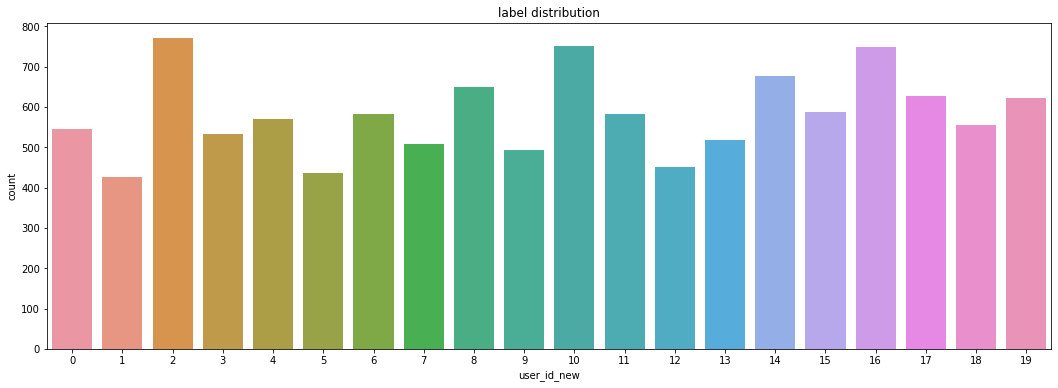

In [9]:
# check how many data we have for each user.
# (Label distribution)

plt.figure(figsize=(18, 6))
plt.subplot(1,1,1)
sns.countplot(df_data['user_id_new'])
plt.title('label distribution')

print(f"max data row :{df_data.groupby('user_id_new')['uid'].count().max()}, \
 min data row: {df_data.groupby('user_id_new')['uid'].count().min()}")

max data row :156,  min data row: 60


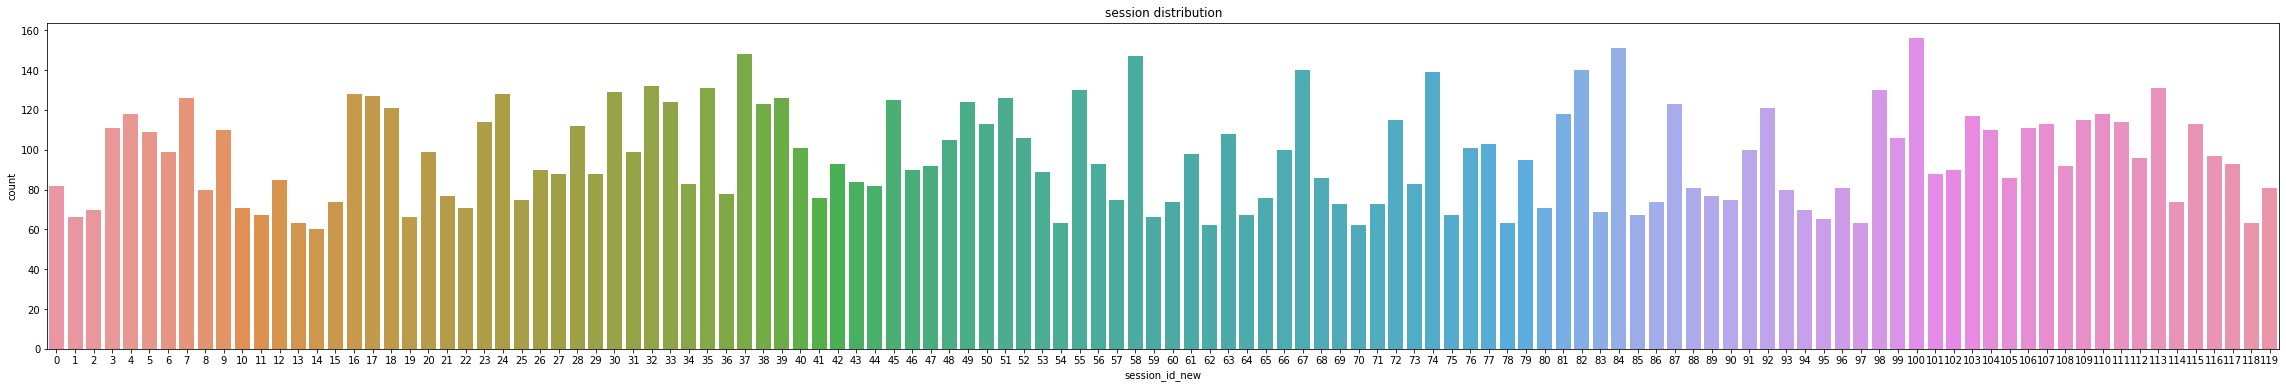

In [10]:
# check how many data we have for each session.
plt.figure(figsize=(40, 6))
plt.subplot(1,1,1)
sns.countplot(df_data['session_id_new'])
plt.title('session distribution')

print(f"max data row :{df_data.groupby('session_id_new')['uid'].count().max()}, \
 min data row: {df_data.groupby('session_id_new')['uid'].count().min()}")

In [11]:
distribution_list = {}
for i in df_data['user_id_new'].unique().tolist():
  distribution_list[i] = df_data[df_data['user_id_new'] == i][['event_type', 'screen_x', 'screen_y']].describe()
distribution_list

{1:        event_type     screen_x    screen_y
 count  426.000000   426.000000  426.000000
 mean     2.504695   562.399061  480.436620
 std      1.121439   377.468385  198.023212
 min      2.000000    17.000000  103.000000
 25%      2.000000   238.000000  335.250000
 50%      2.000000   531.500000  488.000000
 75%      2.000000   818.000000  627.750000
 max      5.000000  1437.000000  899.000000,
 7:        event_type     screen_x     screen_y
 count  509.000000   509.000000   509.000000
 mean     2.414538   831.870334   490.265226
 std      1.005431   448.448698   216.295862
 min      2.000000     0.000000   103.000000
 25%      2.000000   518.000000   337.000000
 50%      2.000000   840.000000   468.000000
 75%      2.000000  1084.000000   660.000000
 max      5.000000  1919.000000  1031.000000,
 19:        event_type     screen_x    screen_y
 count  621.000000   621.000000  621.000000
 mean     2.217391   683.570048  518.342995
 std      0.765856   330.156464  232.944331
 min      2

Insight:   
Different people has different distribution of the screen_x, screen_y.  
We take a look for more details.   

In [12]:
min_row = df_data.groupby('session_id_new')['uid'].count().min()

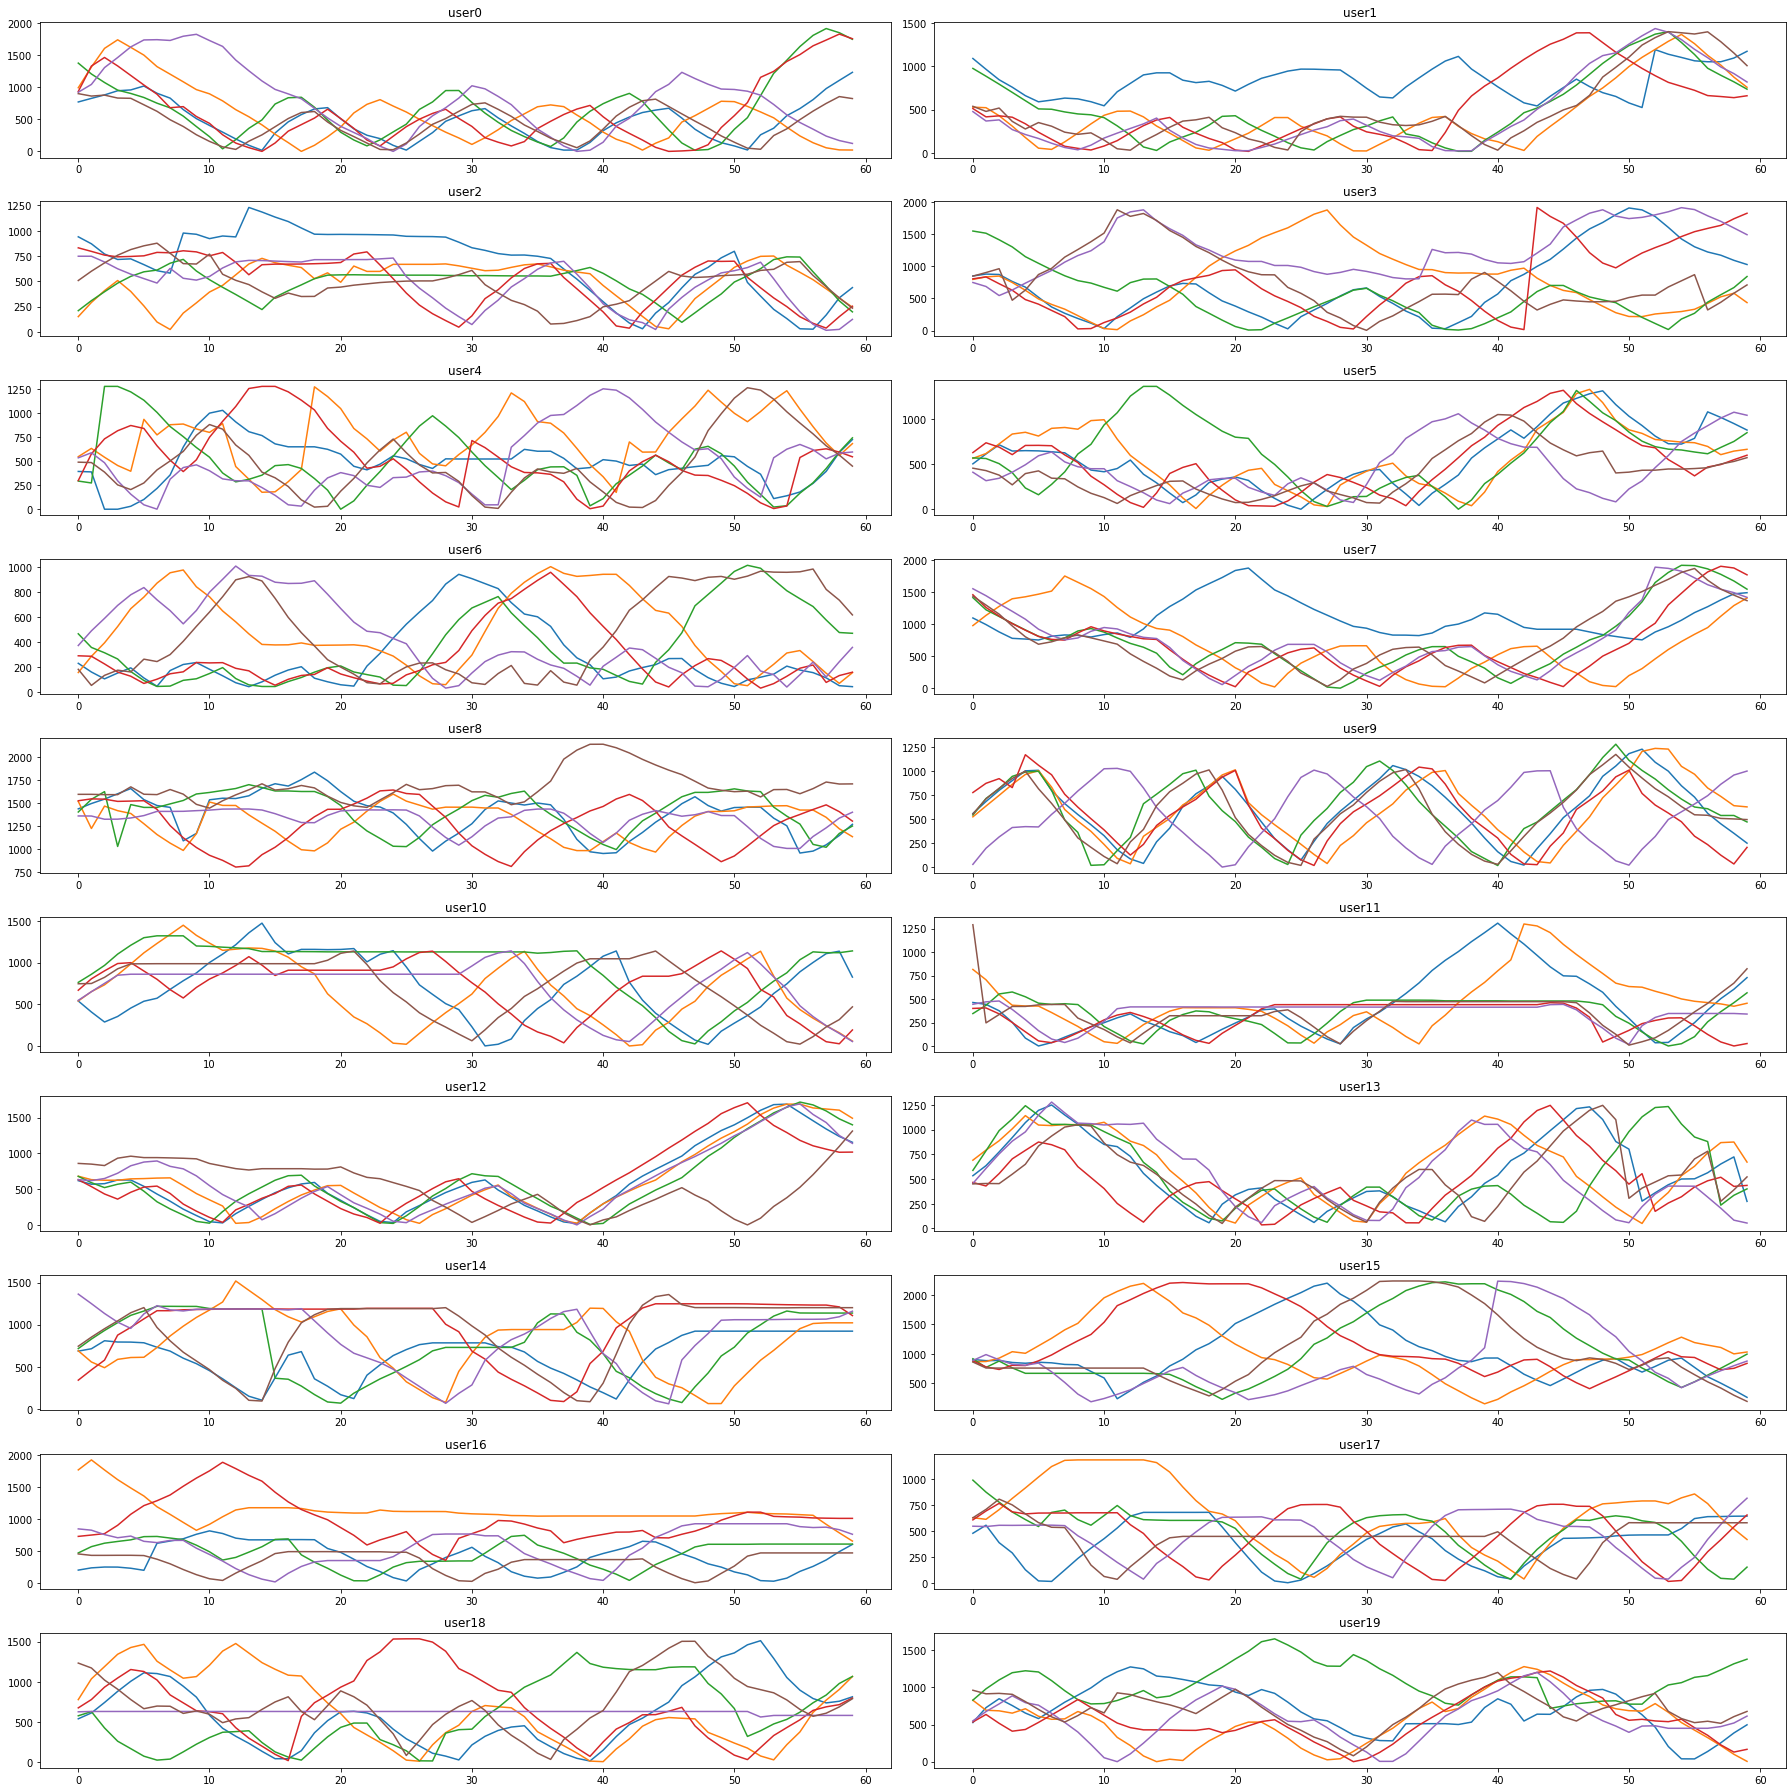

In [13]:
# x position features for each user. each graph shows 6 sessions' data together,
mt = np.arange(min_row)

plt.figure(figsize=(25, 25))
for i in df_data['user_id_new'].unique().tolist():
  plt.subplot(10,2,1+i)
  user_idx_list = df_data[df_data['user_id_new'] == i]['session_id_new'].unique()
  for idx in user_idx_list:
    plt.plot(mt, df_data[(df_data['user_id_new'] == i) & (df_data['session_id_new'] == idx)].screen_x[0: min_row])
  plt.title('user' + str(i))
plt.tight_layout() 
plt.show()

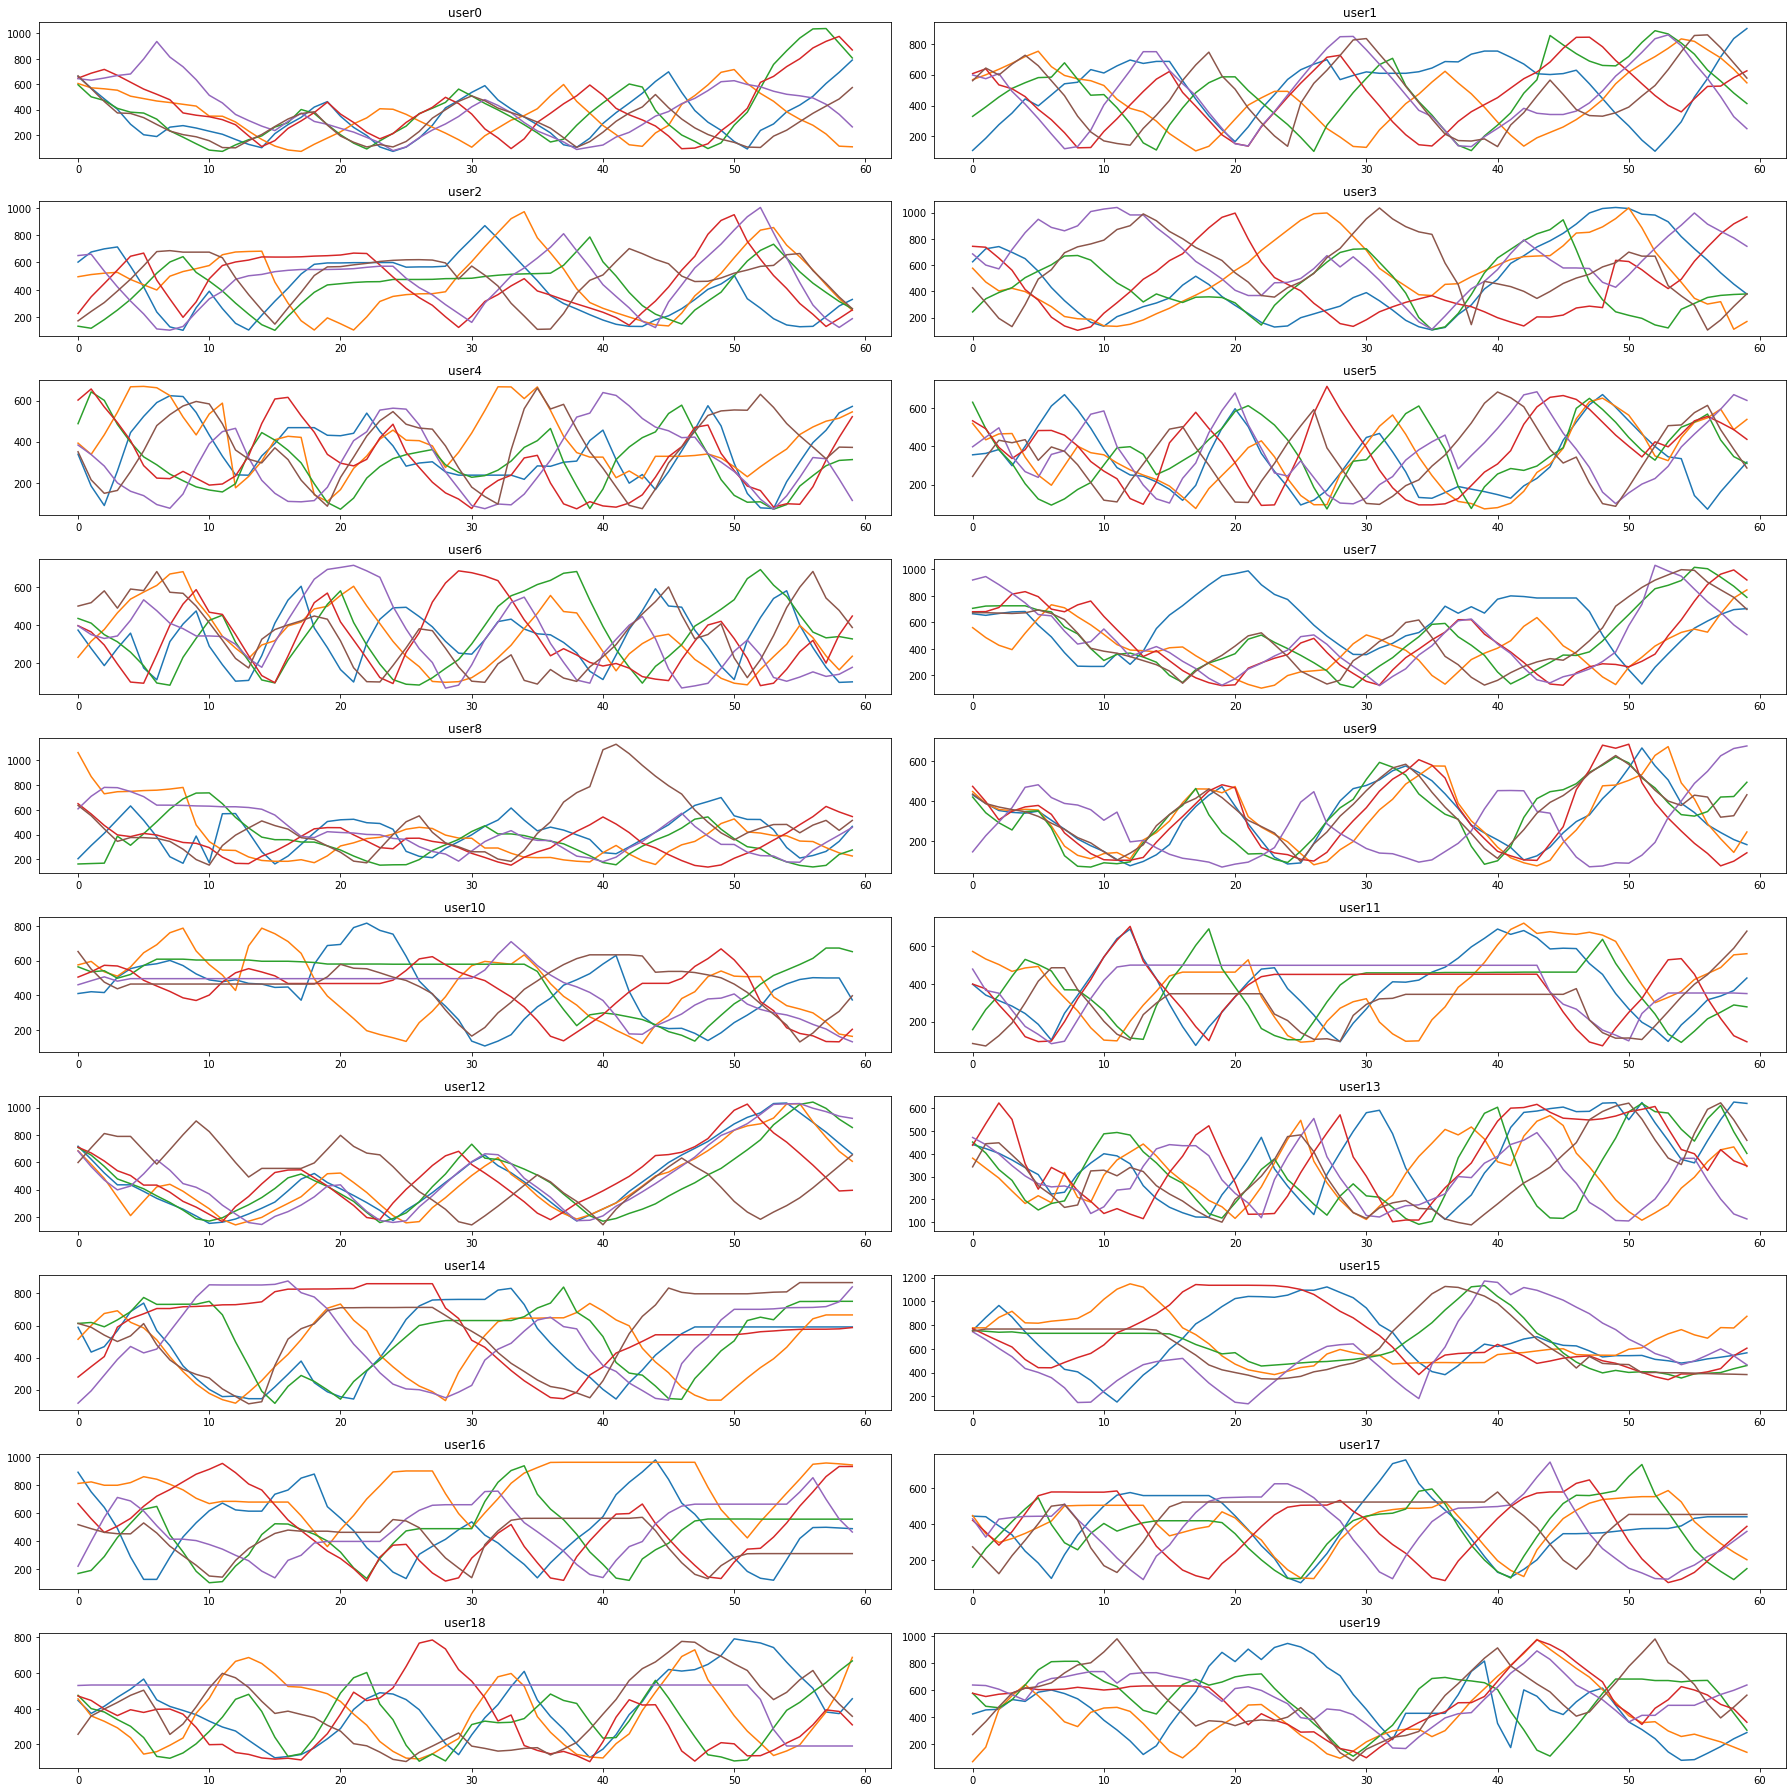

In [14]:
# y position features for each user. each graph shows 6 sessions' data together
mt = np.arange(min_row)

plt.figure(figsize=(25, 25))
for i in df_data['user_id_new'].unique().tolist():
  plt.subplot(10,2,1+i)
  user_idx_list = df_data[df_data['user_id_new'] == i]['session_id_new'].unique()
  for idx in user_idx_list:
    plt.plot(mt, df_data[(df_data['user_id_new'] == i) & (df_data['session_id_new'] == idx)].screen_y[0: min_row])
  plt.title('user' + str(i))
plt.tight_layout() 
plt.show()

Insight:   
The position of x, y are clear different between different user, they are good features as well.   
From the dagrams, we can see one loop is about 20 steps for all the user, so we can use 25-35 steps for getting history data.  

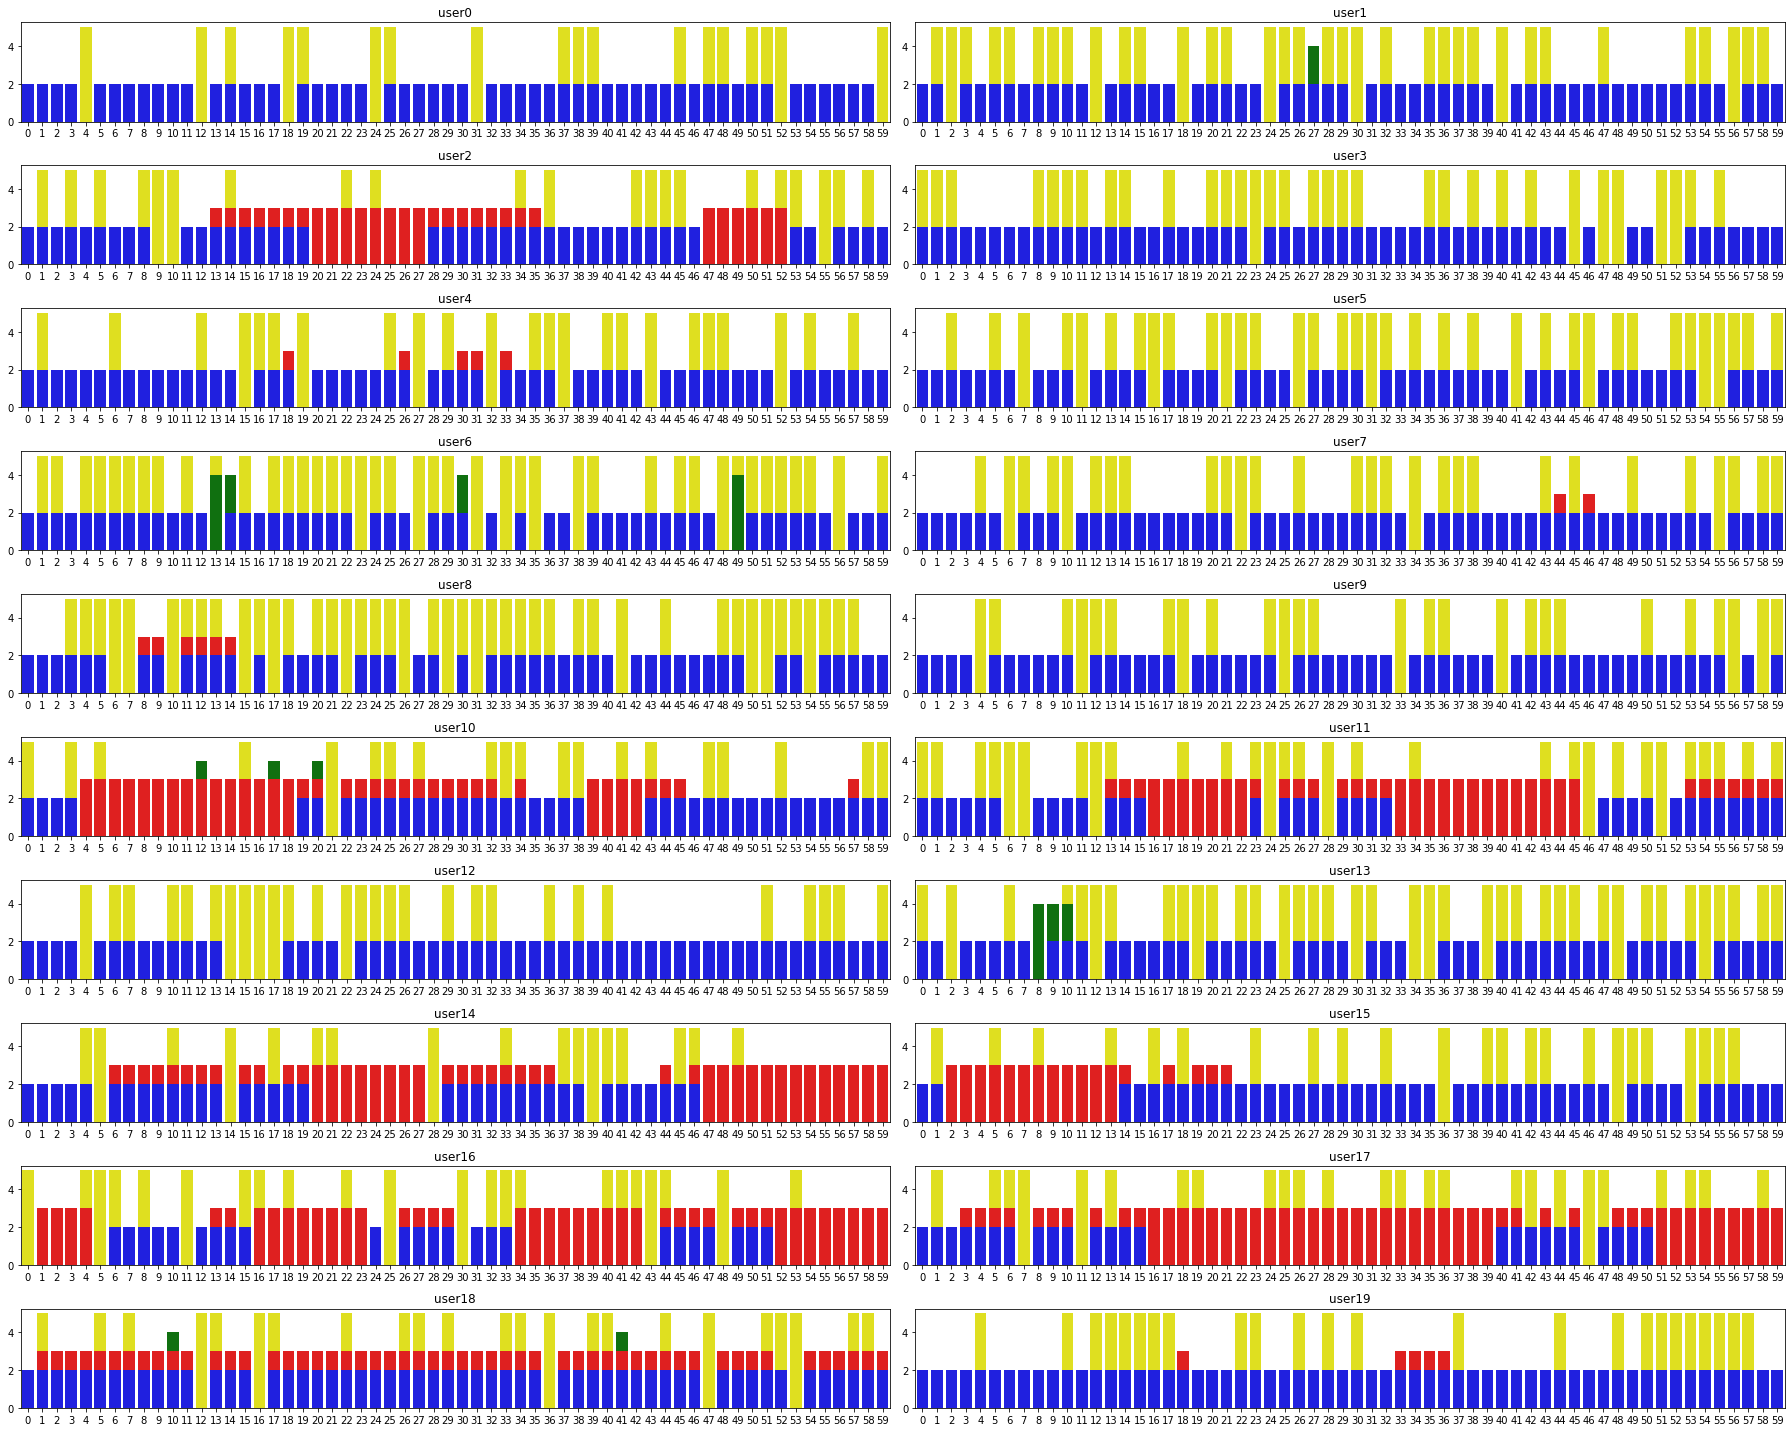

In [6]:
# How many event type each user has

class EventEnum(Enum):
  RELEASE = 1
  MOVE = 2
  WHEEL = 3
  DRAG = 4
  CLICK = 5

class EventColor(Enum):
  RELEASE = 'black'
  MOVE = 'blue'
  WHEEL = 'red'
  DRAG = 'green'
  CLICK = 'yellow'

min_row = df_data.groupby('session_id_new')['uid'].count().min()
mt = np.arange(min_row)
color_mappings = [item.value for item in EventColor]

plt.figure(figsize=(25, 20))
for i in df_data['user_id_new'].unique().tolist():
  plt.subplot(10,2,1+i)
  user_idx_list = df_data[df_data['user_id_new'] == i]['session_id_new'].unique()
  for idx in user_idx_list:
    event_list = df_data[(df_data['user_id_new'] == i) & (df_data['session_id_new'] == idx)].event_type.tolist()[0: min_row]
    colors = [color_mappings[e - 1] for e in event_list]
    sns.barplot(x=mt, y=event_list, palette=colors)
  plt.title('user' + str(i))
plt.tight_layout() 
plt.show()

insight:   
data for each user and each session are quite equal.  
most user didn't use event type 1(release).    
-> no black    
some user rarely use event type 3(wheel) or 4(drag).     
-> red and green only appear in some users' sessions.  
every one use event type 2(move) and 5(click).     
-> blue and yellow appear in all users' sessions.   

It can clear see the difference by user's behavior, so we can create some features:    
1. ratio of each event type / sum.  
2. how many different event type in each session 
3. the order of the event type.  
This is case, we has too little sessions for each user, so any aggragation features can make the model overfittinig, therefore, we don't use these features.   

We use the order as the features (sequence features).  
1. the eventy type order.  
2. the speed of the mouse. (in x, y and xy distance).  
3. the location of the mouse.

# Feature Engineering

In [16]:
'''
# Count the number of each event type in each session:
event_type_session_mapping = df_data.groupby('session_id_new')['event_type'].value_counts()

for i in range(1, 6):
  new_feature_name = 'n_event_type_' + str(i) + '_per_session'
  df_data[new_feature_name] = df_data['session_id_new'].apply(lambda x: event_type_session_mapping[x][i] if i in event_type_session_mapping[x] else 0)

# Calculate the ratio of each event type : counts of event_type / sum in per session
# calculate how many data in each session :
df_data['n_session_data'] = df_data['session_id_new'].apply(lambda x: df_data['session_id_new'].value_counts()[x])

# calculate the ratio of each event type in one session:
for i in range(1, 6):
  new_feature_name = 'event_type_' + str(i) + '_ratio'
  col = 'n_event_type_' + str(i) + '_per_session'
  df_data[new_feature_name] = df_data[col] / df_data['n_session_data']

# calculate how many event type appear in one session
number_event_type_in_session = df_data.groupby('session_id_new')['event_type'].nunique()
df_data['n_event_type'] = df_data['session_id_new'].map(lambda x: number_event_type_in_session[x])

# Input by session
max_values = df_data.groupby('session_id_new')['time_stamp'].max()
min_values = df_data.groupby('session_id_new')['time_stamp'].min()
complete_values = [list(range(min_value, max_value+1)) for min_value, max_value in zip(min_values, max_values)]

list_df_filledna = []
for session_idx, session_id in enumerate(session_id_array):
  complete_df = pd.DataFrame({'time_stamp': complete_values[session_idx]})
  df = df_data[df_data['session_id_new'] == session_idx]
  df_insert = pd.merge(df, complete_df, on='time_stamp', how='outer').sort_values('time_stamp').reset_index()
  df_insert.fillna(method='ffill', inplace=True)
  list_df_filledna.append(df_insert)

len(list_df_filledna)
'''

"\n# Count the number of each event type in each session:\nevent_type_session_mapping = df_data.groupby('session_id_new')['event_type'].value_counts()\n\nfor i in range(1, 6):\n  new_feature_name = 'n_event_type_' + str(i) + '_per_session'\n  df_data[new_feature_name] = df_data['session_id_new'].apply(lambda x: event_type_session_mapping[x][i] if i in event_type_session_mapping[x] else 0)\n\n# Calculate the ratio of each event type : counts of event_type / sum in per session\n# calculate how many data in each session :\ndf_data['n_session_data'] = df_data['session_id_new'].apply(lambda x: df_data['session_id_new'].value_counts()[x])\n\n# calculate the ratio of each event type in one session:\nfor i in range(1, 6):\n  new_feature_name = 'event_type_' + str(i) + '_ratio'\n  col = 'n_event_type_' + str(i) + '_per_session'\n  df_data[new_feature_name] = df_data[col] / df_data['n_session_data']\n\n# calculate how many event type appear in one session\nnumber_event_type_in_session = df_data.

Above features will bring the overfitting in the model, because those features are highly linked to session_id. We have too little sessions for each user (6) in this case.   
so I remove these aggregation features, they can be used in big dataset.   

In [6]:
%%time 
# time features
df_data['datetime'] = pd.to_datetime(df_data['timestamp'], unit='ms')
df_data['day'] = df_data['datetime'].dt.date
df_data['hour'] = df_data['datetime'].dt.hour
df_data['minute'] = df_data['datetime'].dt.minute
df_data['second'] = df_data['datetime'].dt.second
time_features = ['hour', 'minute', 'second']


CPU times: user 20.8 ms, sys: 0 ns, total: 20.8 ms
Wall time: 20.8 ms


In [7]:
# Get the second between 2 clicks, calculate the average of each second, minute

time_btw_click_map = df_data[df_data['event_CLICK'] == 1].groupby('session_id_new')['timestamp'].diff()
df_data['timediff_btw_2_CLICK'] = df_data['index'].apply(lambda x: time_btw_click_map[x] if x in time_btw_click_map.keys()[1:] else 0)
map_session_event_2_sum = df_data.groupby('session_id_new')['timediff_btw_2_CLICK'].sum()
df_data['CLICK_time_sum_per_session'] = df_data['session_id_new'].apply(lambda x: map_session_event_2_sum[x])


In [8]:
%%time
# how many times click in one second, minute, session,
def get_event_frequency(df, groupby_column, prefix ,event_column):
  new_column_name = prefix + event_column
  df[new_column_name] = df_data.groupby(groupby_column)[event_column].transform('sum')
  return df

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.7 µs


In [9]:
# get click, drag, move aggragation features
for i in ['event_DRAG', 'event_CLICK', 'event_MOVE']:
  df_data = get_event_frequency(df_data, ['session_id_new', 'day', 'hour', 'minute', 'second'], 'second_', i)
  df_data = get_event_frequency(df_data, ['session_id_new', 'day', 'hour', 'minute'], 'minute_', i)


In [10]:
print(df_data.columns)

Index(['index', 'uid', 'session_id', 'user_id', 'timestamp', 'event_type',
       'screen_x', 'screen_y', 'user_id_new', 'session_id_new', 'e',
       'event_CLICK', 'event_DRAG', 'event_MOVE', 'event_RELEASE',
       'event_WHEEL', 'datetime', 'day', 'hour', 'minute', 'second',
       'timediff_btw_2_CLICK', 'CLICK_time_sum_per_session',
       'second_event_DRAG', 'minute_event_DRAG', 'second_event_CLICK',
       'minute_event_CLICK', 'second_event_MOVE', 'minute_event_MOVE'],
      dtype='object')


In [11]:
# Time series features:

# speed of the mouse move in x direction.
# speed of the mouse move in y direction.
# speed of the mouse moving.

# timestamp features
df_data['time_stamp_min'] = df_data.groupby('session_id_new')['timestamp'].transform('min')
df_data['time_stamp'] = df_data['timestamp'] - df_data['time_stamp_min']

df_data['time_diff'] = df_data.groupby('session_id_new')['timestamp'].diff()

# calculate the x_diff y_diff and distance btw (x,y)
df_data['x_diff'] = df_data.groupby('session_id_new')['screen_x'].diff()
df_data['y_diff'] = df_data.groupby('session_id_new')['screen_y'].diff()
df_data['xy_diff'] = np.sqrt(df_data['x_diff']**2 + df_data['y_diff']**2)

# calculate the speed
df_data['x_speed'] = np.abs(df_data['x_diff'] / df_data['time_diff'])
df_data['y_speed'] = np.abs(df_data['y_diff'] / df_data['time_diff'])
df_data['xy_speed'] = df_data['xy_diff'] / df_data['time_diff']

df_data_dropna = df_data.dropna()


In [12]:
# get the time ratio of event type in each session
df_data_dropna['sum_time_per_session'] = df_data_dropna.groupby(['session_id_new'])['time_stamp'].transform('max')
df_data_dropna['event_2_time_per_session'] = df_data_dropna['CLICK_time_sum_per_session'] / df_data_dropna['sum_time_per_session']


In [13]:

df_data_dropna['event_time_per_session'] = df_data_dropna[['session_id_new', 'event_type', 'time_diff']].groupby(['session_id_new', 'event_type'])['time_diff'].transform('sum')
# df_data_dropna[['event_time_per_session', 'event_type']]



In [14]:
%%time
# add mean speed, location of each session

def get_mean_features_sec(df, mean_features, groupby_features):
  for column_name in mean_features:
    new_column_name = 'mean_second_' + column_name
    df[new_column_name] = df.groupby(groupby_features)[column_name].transform('mean')
  return df

def get_mean_features_minute(df, mean_features, groupby_features):
  for column_name in mean_features:
    new_column_name = 'mean_minute_' + column_name
    df[new_column_name] = df.groupby(groupby_features)[column_name].transform('mean')
  return df

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.78 µs


In [15]:
mean_features = ['x_speed', 'y_speed', 'xy_speed', 'screen_x', 'screen_y', 'timediff_btw_2_CLICK']
df_mean_sec = get_mean_features_sec(df_data_dropna, mean_features, ['session_id_new', 'day', 'hour', 'minute', 'second'])
df_mean_minute = get_mean_features_minute(df_mean_sec, mean_features, ['session_id_new', 'day', 'hour', 'minute'])


In [27]:
##########. EDA.  #################

distribution_list = {}
for i in df_data['user_id_new'].unique().tolist():
  distribution_list[i] = df_data[df_data['user_id_new'] == i][['x_speed', 'y_speed', 'xy_speed']].describe()
distribution_list


{1:           x_speed     y_speed    xy_speed
 count  420.000000  420.000000  420.000000
 mean     2.316204    2.079743    3.324067
 std      7.279389    6.117570    9.436717
 min      0.000000    0.000000    0.000000
 25%      0.059513    0.063866    0.119275
 50%      0.395445    0.376228    0.623891
 75%      2.592308    2.826480    4.477633
 max    112.000000  114.000000  159.812390,
 7:           x_speed     y_speed    xy_speed
 count  503.000000  503.000000  503.000000
 mean     2.657927    1.566753    3.208091
 std      3.245927    1.965899    3.691436
 min      0.000000    0.000000    0.000000
 25%      0.127622    0.094904    0.213977
 50%      0.884058    0.570000    1.474509
 75%      4.835561    2.666667    5.920453
 max     17.705882   10.625000   18.731023,
 19:           x_speed     y_speed    xy_speed
 count  615.000000  615.000000  615.000000
 mean     1.487199    1.119581    2.019496
 std      1.936615    1.563908    2.362655
 min      0.000000    0.000000    0.000000

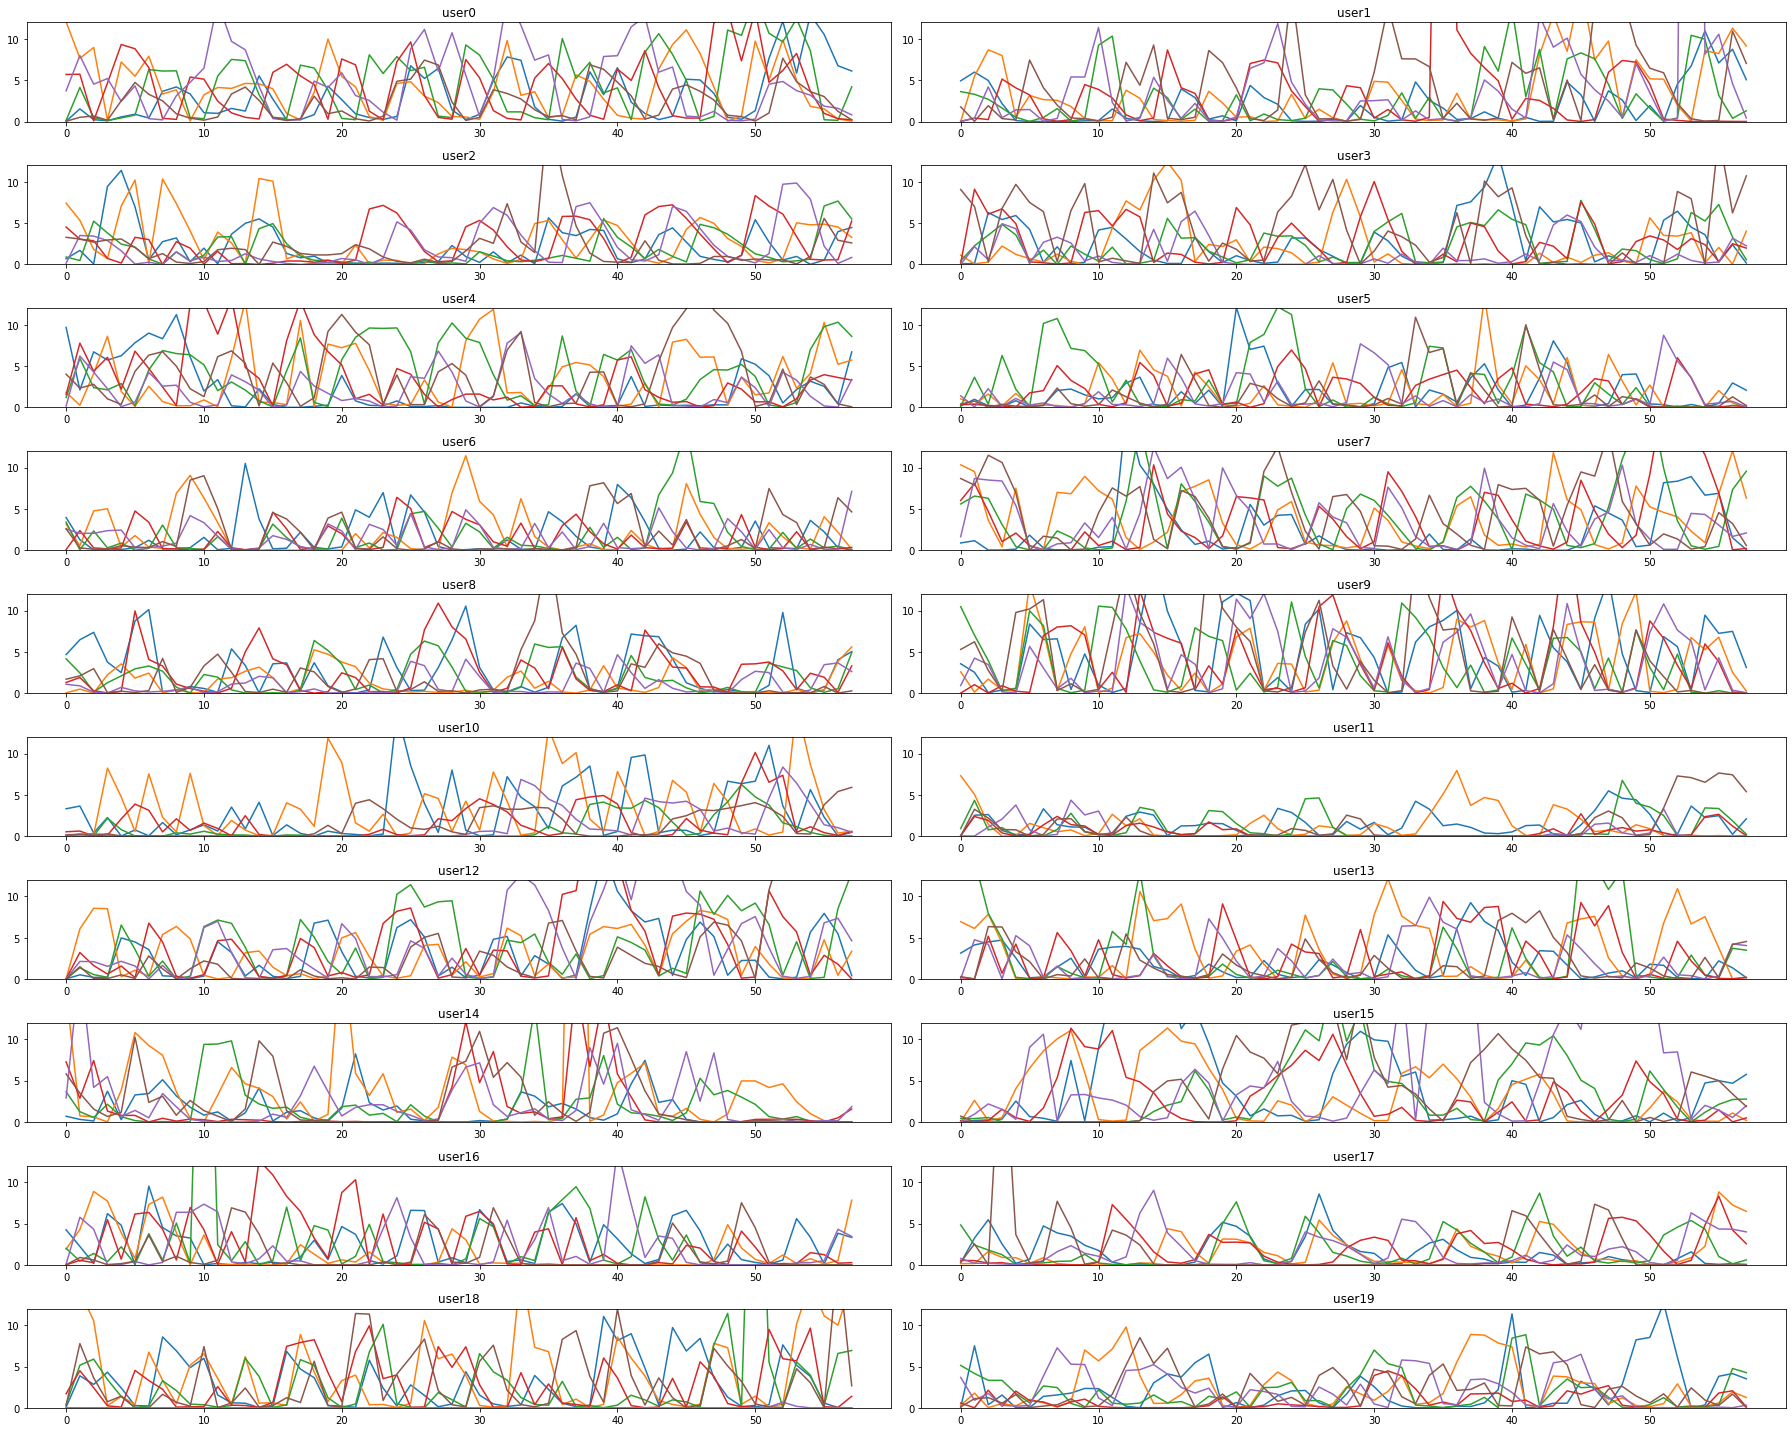

In [34]:
##########. EDA.  #################
# speed features for each user. each graph shows 6 sessions' data together

mt = np.arange(min_row-2)

plt.figure(figsize=(25, 20))
for i in df_data_dropna['user_id_new'].unique().tolist():
  plt.subplot(10,2,1+i)
  user_idx_list = df_data_dropna[df_data_dropna['user_id_new'] == i]['session_id_new'].unique()
  for idx in user_idx_list:
    plt.plot(mt, df_data_dropna[(df_data_dropna['user_id_new'] == i) & (df_data_dropna['session_id_new'] == idx)].xy_speed[0: min_row-2])
    plt.ylim([0, 12])
  plt.title('user' + str(i))
plt.tight_layout() 
plt.show()


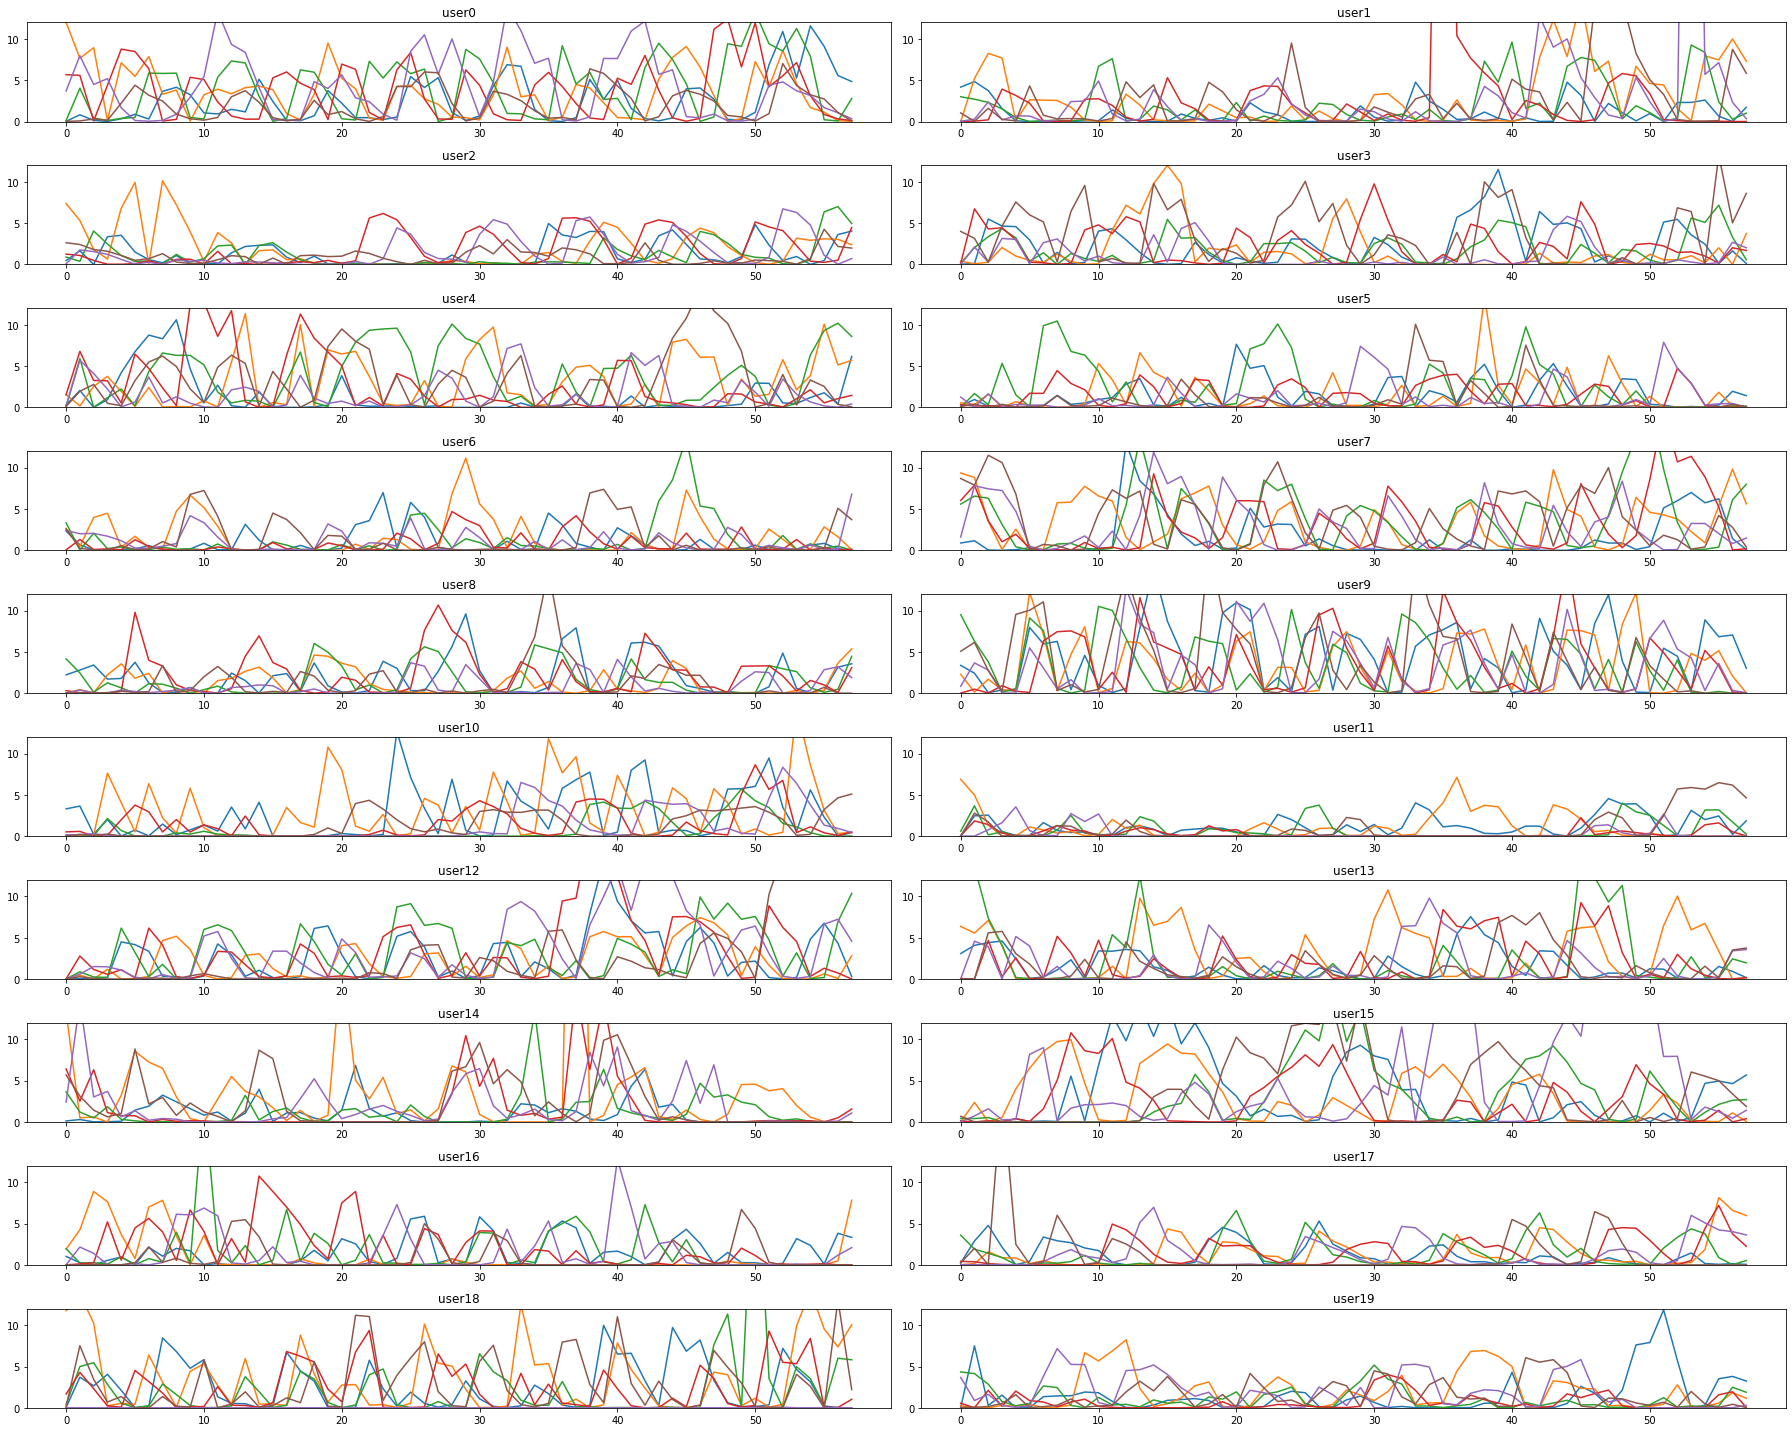

In [35]:
##########. EDA.  #################
# x speed features for each user. each graph shows 6 sessions' data together

mt = np.arange(min_row-2)

plt.figure(figsize=(25, 20))
for i in df_data_dropna['user_id_new'].unique().tolist():
  plt.subplot(10,2,1+i)
  user_idx_list = df_data_dropna[df_data_dropna['user_id_new'] == i]['session_id_new'].unique()
  for idx in user_idx_list:
    plt.plot(mt, df_data_dropna[(df_data_dropna['user_id_new'] == i) & (df_data_dropna['session_id_new'] == idx)].x_speed[0: min_row-2])
    plt.ylim([0, 12])
  plt.title('user' + str(i))
plt.tight_layout() 
plt.show()


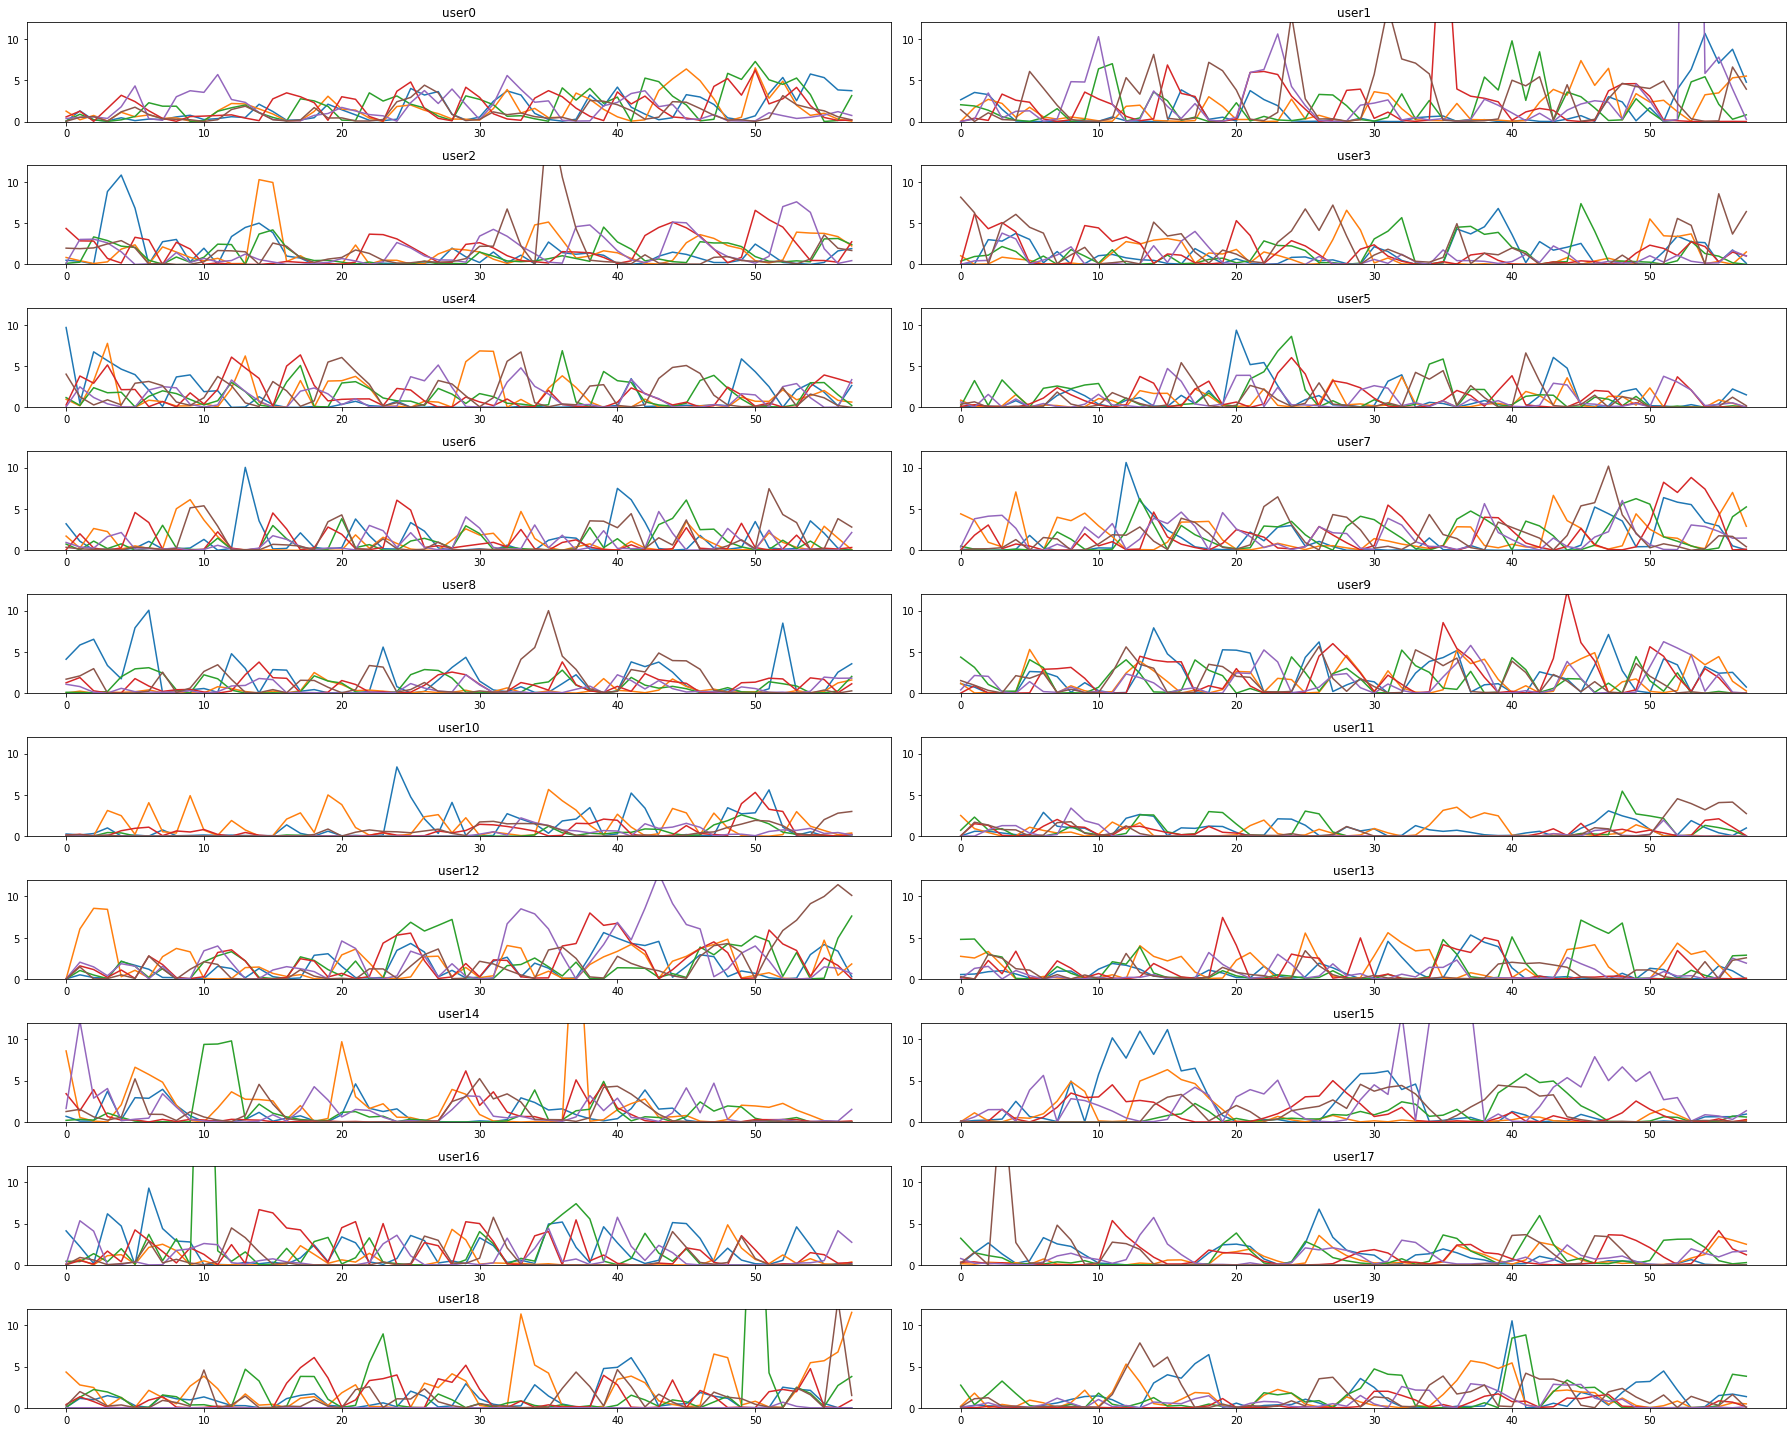

In [36]:
##########. EDA.  #################
# y speed features for each user. each graph shows 6 sessions' data together

mt = np.arange(min_row-2)

plt.figure(figsize=(25, 20))
for i in df_data_dropna['user_id_new'].unique().tolist():
  plt.subplot(10,2,1+i)
  user_idx_list = df_data_dropna[df_data_dropna['user_id_new'] == i]['session_id_new'].unique()
  for idx in user_idx_list:
    plt.plot(mt, df_data_dropna[(df_data_dropna['user_id_new'] == i) & (df_data_dropna['session_id_new'] == idx)].y_speed[0: min_row-2])
    plt.ylim([0, 12])
  plt.title('user' + str(i))
plt.tight_layout() 
plt.show()


Insight:   
The speed changed also shows quite unique pratten for different user.     
From the dagrams, we can see one loop is about 20 steps for all the user, so we can use 25-35 steps for getting history data

In [37]:
# df_mean_minute.columns
# df_mean_minute[['mean_second_timediff_btw_2_CLICK', 'mean_minute_timediff_btw_2_CLICK', 'second_event_CLICK', 'minute_event_CLICK']].iloc[0:30]



# Normalization with MinMaxScaler

In [91]:
# do the normalization

# Select the features to normalize
numerical_cols = [ 'screen_x', 'screen_y',  
                   'x_speed', 'y_speed', 'xy_speed',
                  # 'x_diff', 'y_diff', 'xy_diff',
                  # 'time_stamp', 
                  ]
categorial_cols = ['event_CLICK', 
                   'event_DRAG', 
                   'event_MOVE', 
                   'event_RELEASE',
                   'event_WHEEL']
aggragation_cols = [ 'mean_second_x_speed', 'mean_second_y_speed', 'mean_second_xy_speed', 
                     'mean_second_screen_x', 'mean_second_screen_y', 
                    # 'mean_minute_x_speed', 'mean_minute_y_speed', 'mean_minute_xy_speed', 'mean_minute_screen_x', 'mean_minute_screen_y', 'mean_minute_timediff_btw_2_CLICK',
                    # 'minute', 'second',
                     'second_event_DRAG', 'second_event_CLICK', 'second_event_MOVE', 
                    # 'minute_event_DRAG', 'minute_event_CLICK', 'minute_event_MOVE',
                    # 'event_2_time_per_session', 
                    #  'mean_second_timediff_btw_2_CLICK',
                  ]
time_features = ['hour', 'minute', 'second']
# Initialize the scaler and fit it to the selected columns
scaler = MinMaxScaler()
scaler.fit(df_mean_minute[numerical_cols+aggragation_cols+time_features])

# Transform the selected columns to the scaled values
df_mean_minute[numerical_cols+aggragation_cols+time_features] = scaler.transform(df_mean_minute[numerical_cols+aggragation_cols+time_features])



# Get history features

In [92]:
# add shift features 

def get_shift(n, columns, df, session_column_name):
  features_ = []
  df_data = df
  for i in range(n):
    for c in columns:
      new_feature_name = c + '_shifted_' + str(i+1)
      df_data[new_feature_name] = df_data.groupby(session_column_name)[c].shift(i+1)
      features_ = features_ + [new_feature_name]
  return df_data, features_


In [127]:
# we take 30 step
n_step = 25
df_data, features_add = get_shift(n_step, aggragation_cols, df_mean_minute, 'session_id_new')

In [128]:
df_data.columns

Index(['index', 'uid', 'session_id', 'user_id', 'timestamp', 'event_type',
       'screen_x', 'screen_y', 'user_id_new', 'session_id_new',
       ...
       'second_event_CLICK_shifted_29', 'second_event_MOVE_shifted_29',
       'mean_second_x_speed_shifted_30', 'mean_second_y_speed_shifted_30',
       'mean_second_xy_speed_shifted_30', 'mean_second_screen_x_shifted_30',
       'mean_second_screen_y_shifted_30', 'second_event_DRAG_shifted_30',
       'second_event_CLICK_shifted_30', 'second_event_MOVE_shifted_30'],
      dtype='object', length=668)

# Split dataset - By user id

In [129]:
# get test dataset: each user one session id
def get_valid_idx(df_data_, n, random_seed = False):
  if random_seed:
    random.seed()
  idx_valid = []
  for i in df_data_.groupby('user_id_new')['session_id_new'].unique():
    idx_valid.append(random.sample(list(i), 2)[0])
    idx_valid.append(random.sample(list(i), 2)[1])
  return np.sort(idx_valid)

In [130]:
df_data_ = df_data.dropna()

idx_valid = get_valid_idx(df_data_, 5)
print(f"The session_id picked as test dataset: \n {idx_valid}, \n pick 1 session of each user as the test dataset")


The session_id picked as test dataset: 
 [  1   2   7  16  18  22  24  30  42  42  43  44  47  49  52  54  55  56
  57  65  65  67  68  74  75  77  82  83  86  87  87  89  91 101 101 102
 103 103 104 118], 
 pick 1 session of each user as the test dataset


In [131]:
df_valid = df_data_[df_data_['session_id_new'].isin(idx_valid)]; 
df_train = df_data_[~df_data_.index.isin(df_valid.index)]; 
df_valid = df_valid.reset_index()
df_train = df_train.reset_index()

# Split Data set Random

In [24]:
# left some for validation use:
def get_test_idx(df_data_, random_seed = False):
  if random_seed:
    random.seed()
  idx_valid = []
  for i in df_data_.groupby('user_id_new')['session_id_new'].unique():
    idx_valid.append(random.sample(list(i), 1)[0])
  return np.sort(idx_valid)

df_data_ = df_data.dropna()
idx_test = get_test_idx(df_data_)
print(f"The session_id picked as test dataset: \n {idx_test}, \n pick 1 session of each user as the test dataset")

df_test = df_data_[df_data_['session_id_new'].isin(idx_test)]; 
df_train = df_data_[~df_data_.index.isin(df_test.index)]; 
df_test = df_test.reset_index()
df_train = df_train.reset_index()

The session_id picked as test dataset: 
 [  0   6   8  12  19  29  33  35  42  45  64  66  73  84  97 105 108 109
 110 113], 
 pick 1 session of each user as the test dataset


In [ ]:
df_data_ = df_train
print(int(df_data_.shape[0] * 0.8))
df_train = df_data_.sample(n=int(df_data_.shape[0] * 0.8))
df_valid = df_data_.drop(df_train.index)

df_train.shape, df_valid.shape, df_test.shape

7583


((7583, 37), (1896, 37), (2034, 37))

# Set the label and training features

In [132]:
features_for_train =  features_add + aggragation_cols # numerical_cols + categorial_cols

# get the label as well, check the data shape 
df_train_x = df_train[features_for_train]; df_train_y = df_train['user_id_new'] 
df_valid_x = df_valid[features_for_train];  df_valid_y = df_valid['user_id_new'] 
# when need test dataset: 
# df_test_x = df_test[features_for_train];  df_test_y = df_test['user_id_new'] 

df_train_x.shape, df_valid_x.shape

((5478, 208), (2326, 208))

In [133]:
# check the data
df_train_x.head()

mean_second_x_speed_shifted_1  mean_second_y_speed_shifted_1  \
0                       0.033307                       0.086174   
1                       0.033307                       0.086174   
2                       0.033307                       0.086174   
3                       0.004811                       0.003679   
4                       0.004811                       0.003679   

   mean_second_xy_speed_shifted_1  mean_second_screen_x_shifted_1  \
0                        0.066961                        0.154223   
1                        0.066961                        0.154223   
2                        0.066961                        0.154223   
3                        0.004311                        0.231835   
4                        0.004311                        0.231835   

   mean_second_screen_y_shifted_1  second_event_DRAG_shifted_1  \
0                        0.354255                          0.0   
1                        0.354255                          0.0   
2                        0.354255                          0.0   
3                        0.325064                          0.0   
4                        0.325064                          0.0   

   second_event_CLICK_shifted_1  second_event_MOVE_shifted_1  \
0                           0.0                     0.238095   
1                           0.0                     0.238095   
2                           0.0                     0.238095   
3                           0.0                     0.000000   
4                           0.0                     0.000000   

   mean_second_x_speed_shifted_2  mean_second_y_speed_shifted_2  ...  \
0                       0.033307                       0.086174  ...   
1                       0.033307                       0.086174  ...   
2                       0.033307                       0.086174  ...   
3                       0.033307                       0.086174  ...   
4                       0.004811                       0.003679  ...   

   second_event_CLICK_shifted_25  second_event_MOVE_shifted_25  \
0                            0.0                      0.333333   
1                            0.0                      0.333333   
2                            0.0                      0.333333   
3                            0.0                      0.333333   
4                            0.0                      0.333333   

   mean_second_x_speed  mean_second_y_speed  mean_second_xy_speed  \
0             0.033307             0.086174              0.066961   
1             0.033307             0.086174              0.066961   
2             0.004811             0.003679              0.004311   
3             0.004811             0.003679              0.004311   
4             0.000000             0.000000              0.000000   

   mean_second_screen_x  mean_second_screen_y  second_event_DRAG  \
0              0.154223              0.354255                0.0   
1              0.154223              0.354255                0.0   
2              0.231835              0.325064                0.0   
3              0.231835              0.325064                0.0   
4              0.232062              0.325064                0.0   

   second_event_CLICK  second_event_MOVE  
0                 0.0           0.238095  
1                 0.0           0.238095  
2                 0.0           0.000000  
3                 0.0           0.000000  
4                 0.0           0.000000  

[5 rows x 208 columns]

In [134]:
df_valid_x.head()

mean_second_x_speed_shifted_1  mean_second_y_speed_shifted_1  \
0                       0.052639                       0.010731   
1                       0.086401                       0.011322   
2                       0.086401                       0.011322   
3                       0.086401                       0.011322   
4                       0.086401                       0.011322   

   mean_second_xy_speed_shifted_1  mean_second_screen_x_shifted_1  \
0                        0.037371                        0.364214   
1                        0.060704                        0.352044   
2                        0.060704                        0.352044   
3                        0.060704                        0.352044   
4                        0.060704                        0.352044   

   mean_second_screen_y_shifted_1  second_event_DRAG_shifted_1  \
0                        0.487083                          0.0   
1                        0.497456                          0.0   
2                        0.497456                          0.0   
3                        0.497456                          0.0   
4                        0.497456                          0.0   

   second_event_CLICK_shifted_1  second_event_MOVE_shifted_1  \
0                          0.00                     0.095238   
1                          0.25                     0.190476   
2                          0.25                     0.190476   
3                          0.25                     0.190476   
4                          0.25                     0.190476   

   mean_second_x_speed_shifted_2  mean_second_y_speed_shifted_2  ...  \
0                       0.052639                       0.010731  ...   
1                       0.052639                       0.010731  ...   
2                       0.086401                       0.011322  ...   
3                       0.086401                       0.011322  ...   
4                       0.086401                       0.011322  ...   

   second_event_CLICK_shifted_25  second_event_MOVE_shifted_25  \
0                           0.25                      0.000000   
1                           0.25                      0.047619   
2                           0.25                      0.047619   
3                           0.00                      0.047619   
4                           0.25                      0.000000   

   mean_second_x_speed  mean_second_y_speed  mean_second_xy_speed  \
0             0.086401             0.011322              0.060704   
1             0.086401             0.011322              0.060704   
2             0.086401             0.011322              0.060704   
3             0.086401             0.011322              0.060704   
4             0.086401             0.011322              0.060704   

   mean_second_screen_x  mean_second_screen_y  second_event_DRAG  \
0              0.352044              0.497456                0.0   
1              0.352044              0.497456                0.0   
2              0.352044              0.497456                0.0   
3              0.352044              0.497456                0.0   
4              0.352044              0.497456                0.0   

   second_event_CLICK  second_event_MOVE  
0                0.25           0.190476  
1                0.25           0.190476  
2                0.25           0.190476  
3                0.25           0.190476  
4                0.25           0.190476  

[5 rows x 208 columns]

# XGB

In [135]:
# prepare the dataset
dtrain = xgb.DMatrix(df_train_x.values, label=df_train_y.values)
dvalid = xgb.DMatrix(df_valid_x.values, label=df_valid_y.values)

In [136]:
# define parameter, 20 classes multi-class classification task
n_classes = 20
params = {
    'objective': 'multi:softprob', # multi-class classification
    'num_class': n_classes, # number of classes : 20
    'eval_metric': 'mlogloss', # evaluation metric
    'max_depth': 6, # maximum depth of a tree
    'eta': 0.1, # learning rate
    'min_child_weight': 3, # minimum sum of instance weight needed in a child
    'subsample': 0.8, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing each tree
    'verbosity': 1, # print messages while running boosting
    'reg_alpha': 15, 
    'seed': 42 # random seed
}

In [137]:
modelXGB = xgb.train(params, 
                  dtrain, 
                  num_boost_round=2500, 
                  early_stopping_rounds=10, 
                  evals=[(dtrain, 'train'), (dvalid, 'validation')])

[0]	train-mlogloss:2.75503	validation-mlogloss:2.89653
Multiple eval metrics have been passed: 'validation-mlogloss' will be used for early stopping.

Will train until validation-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.57943	validation-mlogloss:2.8242
[2]	train-mlogloss:2.42676	validation-mlogloss:2.76377
[3]	train-mlogloss:2.30277	validation-mlogloss:2.7164
[4]	train-mlogloss:2.1972	validation-mlogloss:2.6754
[5]	train-mlogloss:2.09886	validation-mlogloss:2.63946
[6]	train-mlogloss:2.014	validation-mlogloss:2.61067
[7]	train-mlogloss:1.93102	validation-mlogloss:2.58544
[8]	train-mlogloss:1.85592	validation-mlogloss:2.56134
[9]	train-mlogloss:1.78505	validation-mlogloss:2.53542
[10]	train-mlogloss:1.71776	validation-mlogloss:2.50647
[11]	train-mlogloss:1.66033	validation-mlogloss:2.48782
[12]	train-mlogloss:1.60768	validation-mlogloss:2.47048
[13]	train-mlogloss:1.55562	validation-mlogloss:2.45138
[14]	train-mlogloss:1.50659	validation-mlogloss:2.43237
[15]	train-ml

# Evaluation

In [138]:
from sklearn.metrics import classification_report

preds_train = modelXGB.predict(dtrain)
y_pred_train = np.argmax(preds_train, axis=1)
print(f"confusion matrix on train dataset: \n {classification_report(df_train_y.values, y_pred_train)}")

preds_valid = modelXGB.predict(dvalid)
y_pred_valid = np.argmax(preds_valid, axis=1)
print(f"confusion matrix on test dataset: \n {classification_report(df_valid_y.values, y_pred_valid)}")


confusion matrix on train dataset: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       220
           1       1.00      0.98      0.99       148
           2       1.00      0.99      1.00       388
           3       0.99      0.98      0.99       251
           4       1.00      1.00      1.00       336
           5       0.99      1.00      0.99       163
           6       1.00      1.00      1.00       225
           7       1.00      1.00      1.00       222
           8       1.00      1.00      1.00       312
           9       0.97      1.00      0.98       246
          10       1.00      0.99      1.00       376
          11       1.00      0.97      0.98       235
          12       1.00      0.99      1.00       186
          13       0.98      0.99      0.98       267
          14       1.00      1.00      1.00       400
          15       1.00      1.00      1.00       292
          16       1.00      1.00      1.00 

In [52]:
# dtest = xgb.DMatrix(df_test_x.values, label=df_test_y.values)

# preds_test = modelXGB.predict(dtest)
# y_pred_test = np.argmax(preds_test, axis=1)
# print(f"confusion matrix on test dataset: \n {classification_report(df_test_y.values, y_pred_test)}")


# Prediction

In [ ]:
df_data_test = pd.read_csv('./Test_Mouse.csv')
print(df_data_test.shape)

print(f"max data row :{df_data.groupby('session_id')['uid'].count().max()}, \
 min data row: {df_data.groupby('session_id')['uid'].count().min()}")

# Make speed features
# sorted the timestamp
df_data_test = df_data_test.sort_values('timestamp').reset_index()

# set session id label_encode
session_id_array = df_data_test['session_id'].unique()
session_id_map = {val:idx for idx,val in enumerate(session_id_array)}
df_data_test['session_id_new'] = df_data_test['session_id'].map(lambda x: session_id_map[x])

# timestamp features
df_data_test['time_diff'] = df_data_test.groupby('session_id_new')['timestamp'].diff()

# calculate the x_diff y_diff and distance btw (x,y)
df_data_test['x_diff'] = df_data_test.groupby('session_id_new')['screen_x'].diff()
df_data_test['y_diff'] = df_data_test.groupby('session_id_new')['screen_y'].diff()
df_data_test['xy_diff'] = np.sqrt(df_data_test['x_diff']**2 + df_data_test['y_diff']**2)

# calculate the speed
df_data_test['x_speed'] = np.abs(df_data_test['x_diff'] / df_data_test['time_diff'])
df_data_test['y_speed'] = np.abs(df_data_test['y_diff'] / df_data_test['time_diff'])
df_data_test['xy_speed'] = df_data_test['xy_diff'] / df_data_test['time_diff']

df_data_test_dropna = df_data_test.dropna()

df_data_test_dropna[numerical_cols] = scaler.transform(df_data_test_dropna[numerical_cols])
df_data_test_dropna[numerical_cols + categorial_cols + ['session_id_new']]

df_data_test, features_add = get_shift(n_step, numerical_cols + categorial_cols, df_data_test_dropna, 'session_id_new')
df_data_test = df_data_test[numerical_cols + categorial_cols + features_add + ['session_id_new']]

df_data_test = df_data_test.dropna().astype(float)
df_data_test_ = df_data_test[numerical_cols + categorial_cols + features_add]
df_data_test_.shape

In [ ]:
# predict

test_p = xgb.DMatrix(df_data_test_.values)
p = modelXGB.predict(test_p)
y_pred_test_ = np.argmax(p, axis=1)
print(len(y_pred_test_))

df_data_test['user_id'] = y_pred_test_
result_map = df_data_test[['user_id', 'session_id_new']].groupby('session_id_new')['user_id'].apply(lambda x: x.mode()[0])


2862


In [ ]:
# map back to the user_id, and save the result

df_data_test = pd.read_csv('./Test_Mouse.csv')
df_data_test['user_id'] = df_data_test['session_id'].apply(lambda x: user_id_array[result_map[session_id_map[x]]])
df_data_test.to_csv('result_xgb.csv', index=False)